See if we can recreate DelRosso ddG results from FINCHES

1. Visual comparison of heatmaps
2. Linear regression?

In [358]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
import scipy.stats as stat

In [359]:
finches_results = pd.read_csv("DelRosso_AD_coA_results.csv")
Kds = pd.read_csv("DelRossoBindingAffinities.csv", index_col="Variant_ID")
binding_binary = pd.read_csv("DelRossoBindingBinary.csv", index_col="Variant_ID")

In [360]:
### calculate dG
R = 8.314
T = 298
def deltaG(R, T, Kd):
    return -R*T*np.log2(Kd)

dGs = Kds.map(lambda x: deltaG(R, T, x))

megfp = dGs.iloc[-1]
dGsADs = dGs.loc[[x for x in dGs.index.to_list() if "mEGFP" not in x]]

In [361]:
#calculate ddG using reference meGFP
ddGsADs = pd.DataFrame()
for col in range(dGs.shape[1]):
    columnlabel = dGs.columns.to_list()[col]
    reference_dG = megfp[columnlabel]
    ddGsADs[columnlabel] = dGsADs[columnlabel] - reference_dG

ddGsADs.head()

,BRD7,P300,P300 KIX,P300 NCBD,P300 TAZ1,P300 TAZ2,TFIID TAF12,PCAF TAF6L
Variant_ID,,,,,,,,
AKAP8;0,0.000000,2980.497699,979.717314,658.278820,0.000000,3591.227563,0.0,0.0
APBB1;22,0.000000,7006.140916,0.000000,854.410045,1723.880504,3939.104226,0.0,0.0
ARGFX;14,98.375512,6275.503827,0.000000,1160.427004,28.732055,0.000000,0.0,0.0
ARGFX;23,0.000000,3672.952926,0.000000,926.824548,649.511137,1715.745254,0.0,0.0
ARNTL2;54,0.000000,2535.842091,0.000000,780.223391,0.000000,4377.835614,0.0,0.0


In [362]:
pivot_results = finches_results.drop_duplicates().pivot(index="Prot1", columns="Prot2", values="Total e (mf)")
pivot_results = pivot_results.rename({"P300_NCOA": "P300_NCBD"}, axis=1)
pivot_results.columns = [x.replace("_", " ") for x in pivot_results.columns.to_list()]
pivot_results = pivot_results.loc[[x for x in dGs.index.to_list() if "mEGFP" not in x]]
pivot_results.head()

,BRD4 Bromo1,BRD4 Bromo2,MED15,MED15 disorder region 1,MED15 disorder region 2,MED15 folded region 1,MED15 folded region 2,MED15 folded region 3,MED9,P300 Bromo,P300 CBP HAT,P300 KIX,P300 NCBD,P300 TAZ1,P300 TAZ2,P300 ZZ type,TFIID TAF12,TFIID TAF9
Prot1,,,,,,,,,,,,,,,,,,
AKAP8;0,-3.880225,-2.658071,-1.951654,0.071501,-2.244219,-1.592699,-6.152348,-0.865210,-0.744956,-3.692535,-1.444063,-2.069824,-3.469373,-2.735773,-1.879265,-2.366308,-0.150493,0.165826
APBB1;22,-3.633734,-1.703321,-1.849181,0.245792,-2.068536,-1.524225,-6.590845,-0.679763,-0.458198,-2.946329,-1.280548,-1.787427,-4.182109,-4.224660,-4.010861,-2.110794,0.132875,0.532982
ARGFX;14,-3.373205,-2.065569,-0.907094,1.402500,-1.098203,-0.502586,-5.567550,0.117839,0.022741,-3.131509,-0.628622,-1.413842,-2.356684,-1.300125,-0.304610,-1.753784,0.632069,1.019241
ARGFX;23,-2.496042,-0.991979,-0.441645,1.784674,-0.490603,-0.366691,-4.921382,0.482778,0.738341,-2.037075,-0.116103,-0.856376,-2.272758,-2.162196,-1.586724,-1.030183,1.244886,1.683070
ARNTL2;54,-0.783743,0.900932,0.822554,2.980221,0.847567,0.938020,-3.730807,1.710525,2.171699,-0.141082,1.477574,0.769553,-1.071074,-1.418657,-1.255141,0.941590,2.629404,3.022749


In [363]:
#get shared columns
pivot_results_select = pivot_results[[x for x in pivot_results.columns.to_list() if x in ddGsADs.columns.to_list()]]
ddG_select = ddGsADs[[x for x in ddGsADs.columns.to_list() if x in pivot_results.columns.to_list()]]

#normalize across domains
pivot_results_select = pivot_results_select.apply(zscore, axis=0)

#ddG has NaN values, impute via KNNImputer
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2, weights="uniform")
ddG_imputed = ddG_select.copy()

ddG_imputed[ddG_select.columns.to_list()] = imputer.fit_transform(ddG_select)

ddG_imputed = ddG_imputed.apply(zscore, axis=0)


Text(404.14361505486755, 0.5, '')

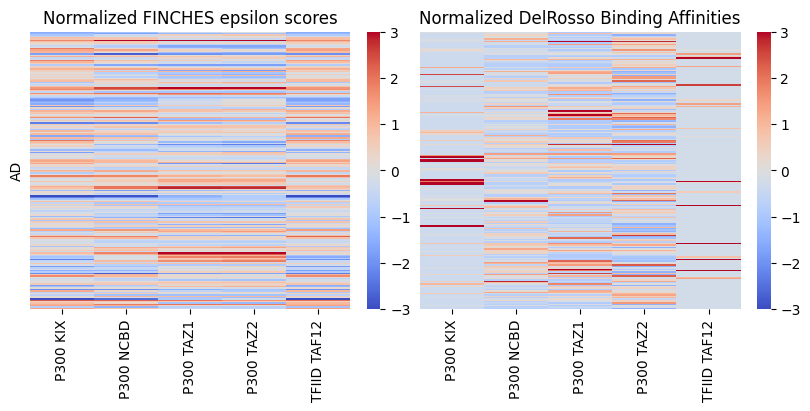

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8,4), layout="compressed")
ax1 = sns.heatmap(pivot_results_select, vmin=-3, vmax=3, cmap="coolwarm", ax=ax1)
ax1.tick_params(labelrotation=90)
ax1.set_title("Normalized FINCHES epsilon scores")
ax1.set_ylabel("AD")
ax2 = sns.heatmap(ddG_imputed, vmin=-3, vmax=3, cmap="coolwarm", ax=ax2, yticklabels=False)
ax2.set_title("Normalized DelRosso ΔΔG")
ax2.set_ylabel("")

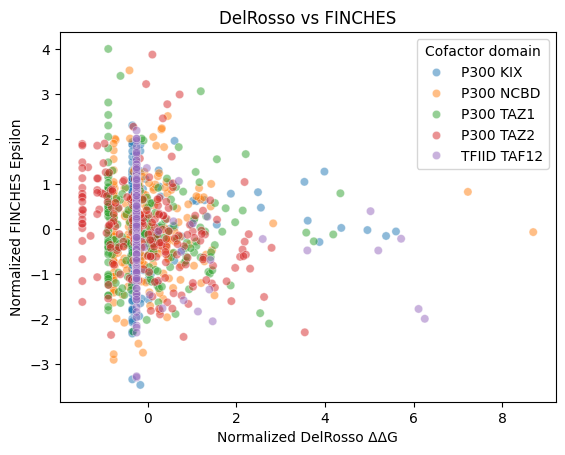

In [365]:
#melted, not normalized
finches_results_select_melt = pivot_results_select.reset_index().melt(id_vars="Prot1", var_name="Cofactor domain", value_name="Normalized FINCHES Epsilon").rename({"Prot1": "AD"}, axis=1)
ddG_imputed_melt = ddG_imputed.reset_index().melt(id_vars="Variant_ID", var_name="Cofactor domain", value_name="Normalized DelRosso ΔΔG").rename({"Variant_ID": "AD"}, axis=1)
merged = finches_results_select_melt.merge(ddG_imputed_melt, left_on=["AD", "Cofactor domain"], right_on=["AD", "Cofactor domain"])

sns.scatterplot(merged, x = "Normalized DelRosso ΔΔG", y = "Normalized FINCHES Epsilon", hue="Cofactor domain", alpha=0.5)
plt.legend(title = "Cofactor domain", bbox_to_anchor=(1,1))
plt.title("DelRosso vs FINCHES")
plt.savefig("scatterplot_delrosso_finches", bbox_inches="tight")

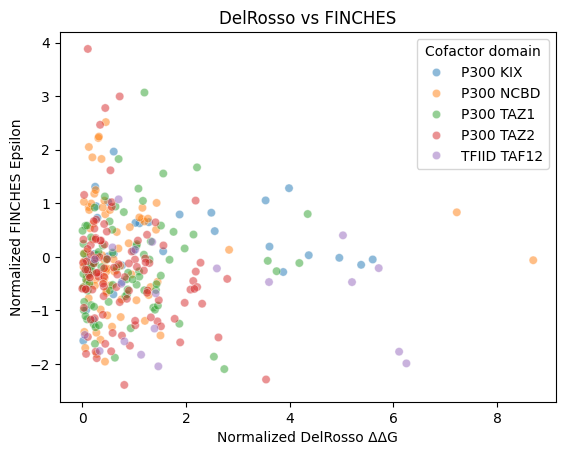

In [366]:
#greater than 0
finches_results_select_melt = pivot_results_select.reset_index().melt(id_vars="Prot1", var_name="Cofactor domain", value_name="Normalized FINCHES Epsilon").rename({"Prot1": "AD"}, axis=1)
ddG_imputed_melt = ddG_imputed.reset_index().melt(id_vars="Variant_ID", var_name="Cofactor domain", value_name="Normalized DelRosso ΔΔG").rename({"Variant_ID": "AD"}, axis=1)
merged = finches_results_select_melt.merge(ddG_imputed_melt, left_on=["AD", "Cofactor domain"], right_on=["AD", "Cofactor domain"])
merged = merged[merged["Normalized DelRosso ΔΔG"] > 0]

sns.scatterplot(merged, x = "Normalized DelRosso ΔΔG", y = "Normalized FINCHES Epsilon", hue="Cofactor domain", alpha=0.5)
plt.legend(title = "Cofactor domain", bbox_to_anchor=(1,1))
plt.title("DelRosso vs FINCHES")
plt.savefig("scatterplot_delrosso_finches", bbox_inches="tight")

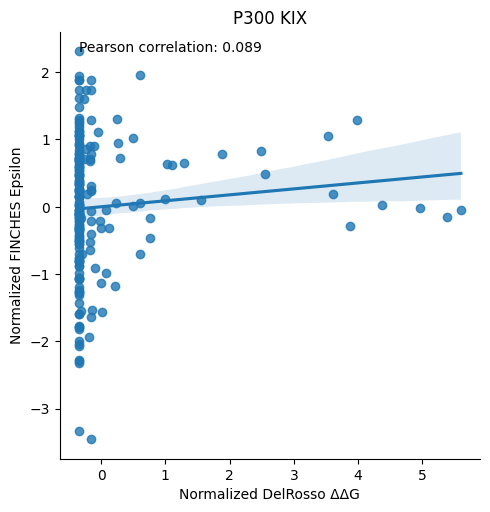

<Figure size 640x480 with 0 Axes>

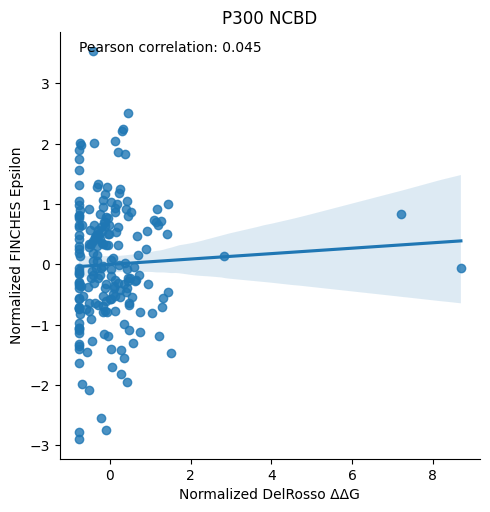

<Figure size 640x480 with 0 Axes>

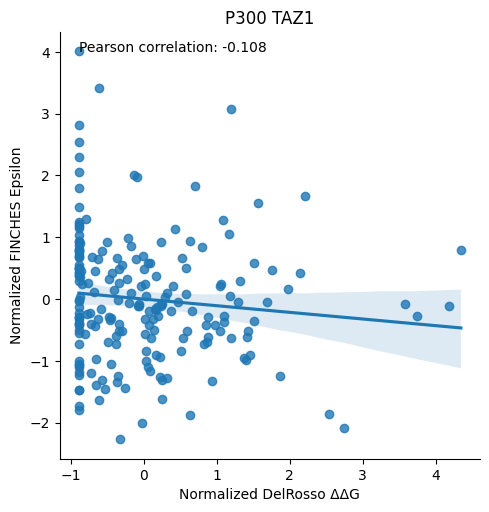

<Figure size 640x480 with 0 Axes>

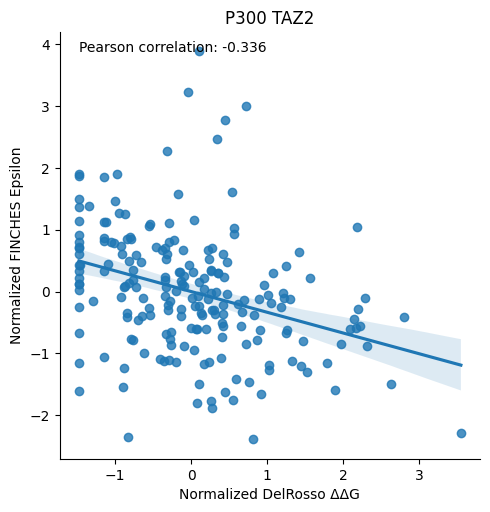

<Figure size 640x480 with 0 Axes>

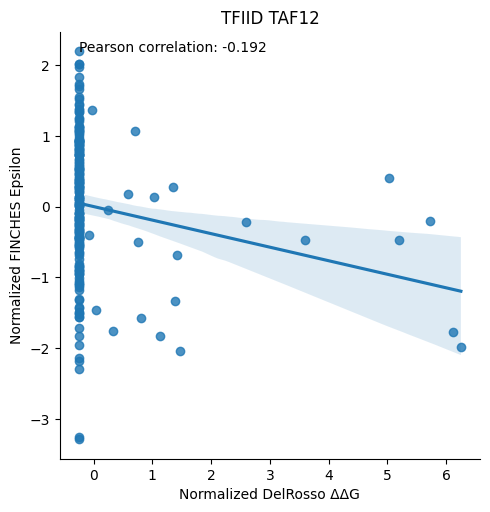

<Figure size 640x480 with 0 Axes>

In [367]:
merged = finches_results_select_melt.merge(ddG_imputed_melt, left_on=["AD", "Cofactor domain"], right_on=["AD", "Cofactor domain"])

for cofactor in merged["Cofactor domain"].unique():
    cofactor_only = merged[merged["Cofactor domain"] == cofactor]
    sns.lmplot(cofactor_only, x = "Normalized DelRosso ΔΔG", y = "Normalized FINCHES Epsilon")
    x = cofactor_only["Normalized DelRosso ΔΔG"]
    y = cofactor_only["Normalized FINCHES Epsilon"]
    s, p = stat.pearsonr(x, y)
    plt.text(x = min(x), y = max(y), s = "Pearson correlation: " + str(np.round(s, 3)))
    plt.title(cofactor)
    plt.savefig("scatterplots/{}.png".format(cofactor))
    plt.show()
    plt.clf()


In [368]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve

In [389]:
binding_binary.columns = [x.replace(" binder", "") for x in binding_binary.columns]

pivot_results_binary_select = pivot_results[[x for x in pivot_results.columns.to_list() if x in binding_binary.columns.to_list()]]
binding_binary_select = binding_binary[pivot_results_binary_select.columns.to_list()]
binding_binary_select = binding_binary_select.loc[[x for x in binding_binary_select.index.to_list() if "mEGFP" not in x]]

In [405]:
#maximize parameter for auroc

pivot_results_binary_select_melt = pivot_results_binary_select.reset_index().melt(id_vars="Prot1", var_name="Domain", value_name="Interacts")
binding_binary_select_melt = binding_binary_select.reset_index().melt(id_vars="Variant_ID", var_name="Domain", value_name="Interacts")

def binary(val, cutoff):
    if val >= cutoff:
        return 0
    else:
        return 1

Kd_col = binding_binary_select_melt["Interacts"]
max_auc = 0
ideal_cutoff = 0

pivot_results_binary_select = pivot_results[[x for x in pivot_results.columns.to_list() if x in binding_binary.columns.to_list()]]
pivot_results_binary_select_melt = pivot_results_binary_select.reset_index().melt(id_vars="Prot1", var_name="Domain", value_name="Interacts")

for cutoff in np.arange(0, -5, -0.01):
    finches_binary_test = pivot_results_binary_select_melt["Interacts"].apply(lambda x: binary(x, cutoff))
    auc = roc_auc_score(Kd_col, finches_binary_test)
    if auc >= max_auc:
        max_auc = auc
        ideal_cutoff = cutoff

print(ideal_cutoff, max_auc)

pivot_results_binary_select = pivot_results_binary_select.map(lambda x: binary(x, ideal_cutoff))
pivot_results_binary_select_melt = pivot_results_binary_select.reset_index().melt(id_vars="Prot1", var_name="Domain", value_name="Interacts")

-0.23 0.6215746421267894


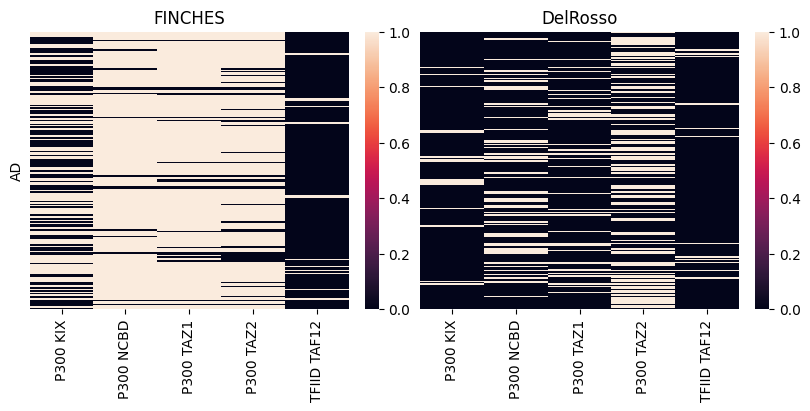

In [406]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8,4), layout="compressed")
ax1 = sns.heatmap(pivot_results_binary_select, vmin=0, vmax=1, ax=ax1)
ax1.tick_params(labelrotation=90)
ax1.set_title("FINCHES")
ax1.set_ylabel("AD")
ax2 = sns.heatmap(binding_binary_select, vmin=0, vmax=1, ax=ax2, yticklabels=False)
ax2.set_title("DelRosso")
ax2.set_ylabel("")
plt.savefig("DelRosso_FINCHES_binary.png")

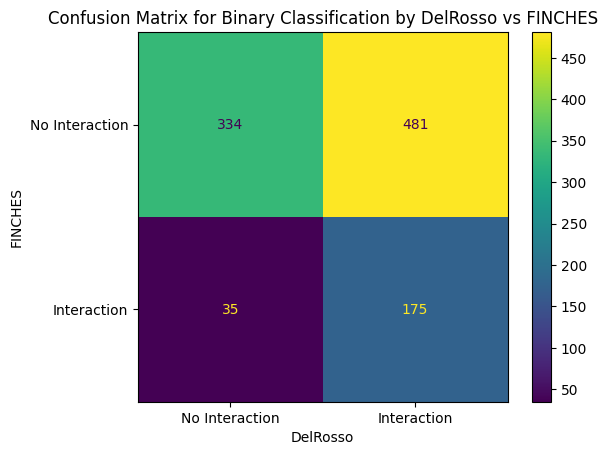

<Figure size 640x480 with 0 Axes>

In [415]:
#all
cm = confusion_matrix(binding_binary_select_melt["Interacts"], pivot_results_binary_select_melt["Interacts"], labels=[0, 1])
disp = ConfusionMatrixDisplay(cm, display_labels=("No Interaction", "Interaction"))
disp.plot()
plt.xlabel("DelRosso")
plt.ylabel("FINCHES")
plt.title("Confusion Matrix for Binary Classification by DelRosso vs FINCHES")
plt.savefig("confusionmatrix_delrosso_finches", bbox_inches="tight")
plt.show()
plt.clf()


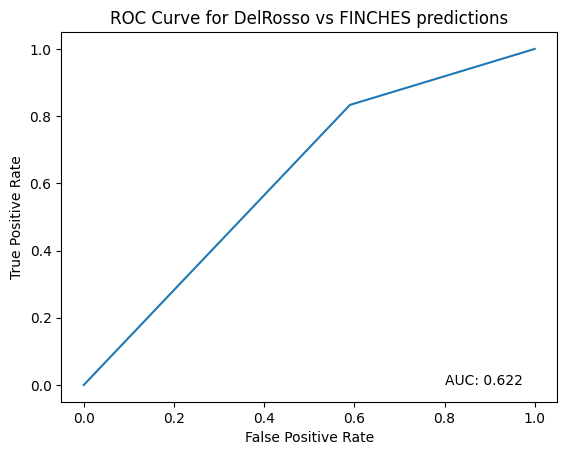

<Figure size 640x480 with 0 Axes>

In [416]:
Kd_col = binding_binary_select_melt["Interacts"]
finches_result_col = pivot_results_binary_select_melt["Interacts"]
fpr, tpr, thresholds = roc_curve(Kd_col, finches_result_col)
auc = roc_auc_score(Kd_col, finches_result_col)
plt.plot(fpr, tpr)
plt.text(x = 0.8, y = 0, s="AUC: "+ str(np.round(auc, 3)))
plt.title("ROC Curve for DelRosso vs FINCHES predictions")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.savefig("roc_curve", bbox_inches="tight")
plt.show()
plt.clf()

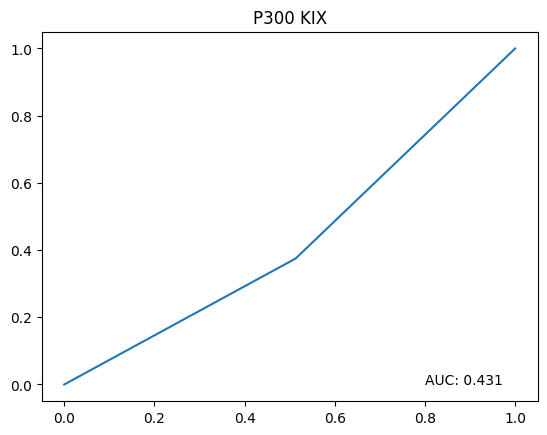

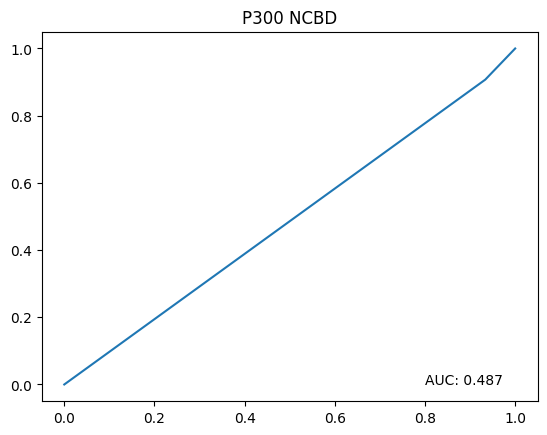

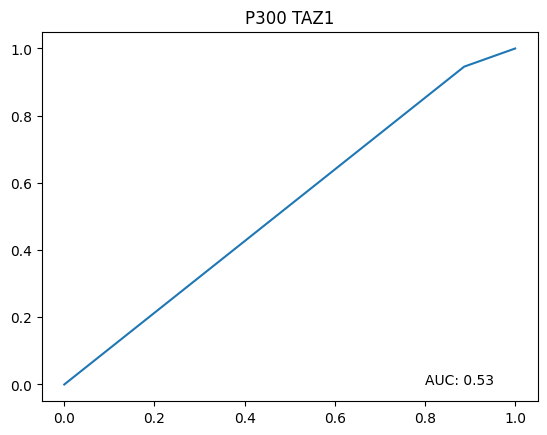

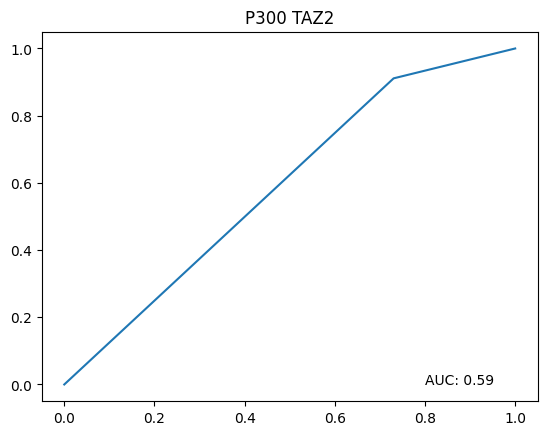

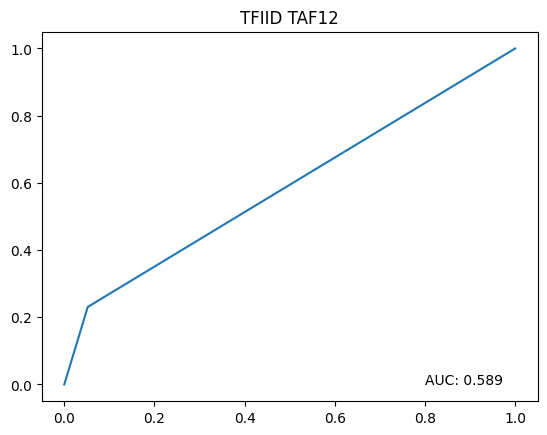

<Figure size 640x480 with 0 Axes>

In [409]:
for i in range(binding_binary_select.shape[1]):
    label = pivot_results_select.columns.to_list()[i]
    Kd_col = binding_binary_select.iloc[:, i].to_list()
    finches_result_col = pivot_results_binary_select.iloc[:, i].to_list()
    fpr, tpr, thresholds = roc_curve(Kd_col, finches_result_col)
    auc = roc_auc_score(Kd_col, finches_result_col)
    plt.plot(fpr, tpr)
    plt.text(x = 0.8, y = 0, s="AUC: "+ str(np.round(auc, 3)))
    plt.title(label)
    plt.show()
    plt.clf()